### Modeling voltage threshold classification at 2.5 V using XGBoost with SELFIES data (no augmentation applied)

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import saved files
df_All = pd.read_csv('OrganicElectrodesAll.csv')

In [3]:
df_All.shape

(1857, 2)

In [4]:
df_All.head()

,Voltage,SMILES
0,2.95,O=C1C2=C(O)C=CC(O)=C2C(=O)C2=C1C(=O)C1=C(C2=O)...
1,2.40,O=C(C1=C(C(S(=O)(O[Na])=O)=CC=C1)C2=O)C3=C2C=C...
2,2.40,OC(C1=C2C=CC=C1S(=O)(O)=O)=C3C(C(S(=O)(O)=O)=C...
3,2.25,O=C1C2=C(C=CC=C2)C(=O)C2=C1C=CC=C2S(=O)(=O)O[Na]
4,2.25,OC(C1=C2C=CC=C1S(=O)(O)=O)=C3C(C=CC=C3)=C2O


### Exploratory Data Analysis (EDA)

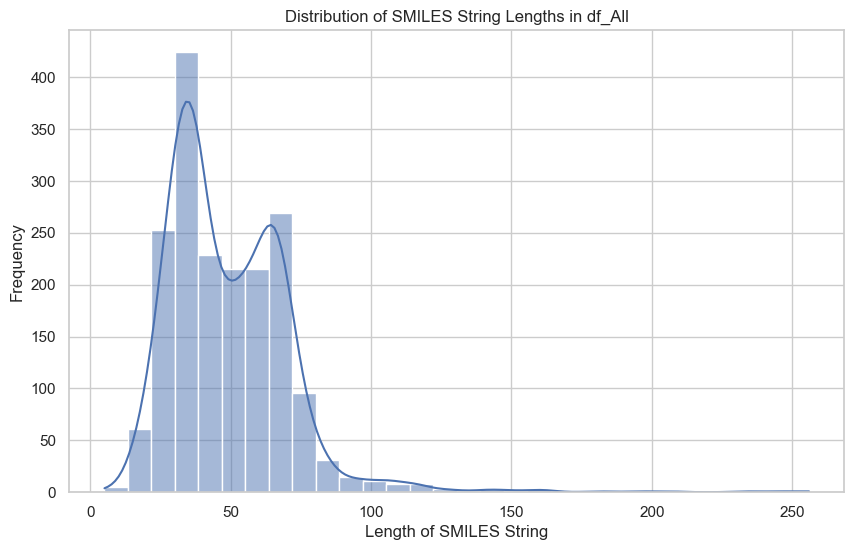

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each SMILES string
df_All['length'] = df_All['SMILES'].apply(len)

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(df_All['length'], bins=30, kde=True)

# Set the plot title and labels
plt.title('Distribution of SMILES String Lengths in df_All')
plt.xlabel('Length of SMILES String')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [6]:
max_length_All = df_All['SMILES'].apply(len).max()

print("The maximum length of SMILES strings in the df_All DataFrame is:", max_length_All)

The maximum length of SMILES strings in the df_All DataFrame is: 256


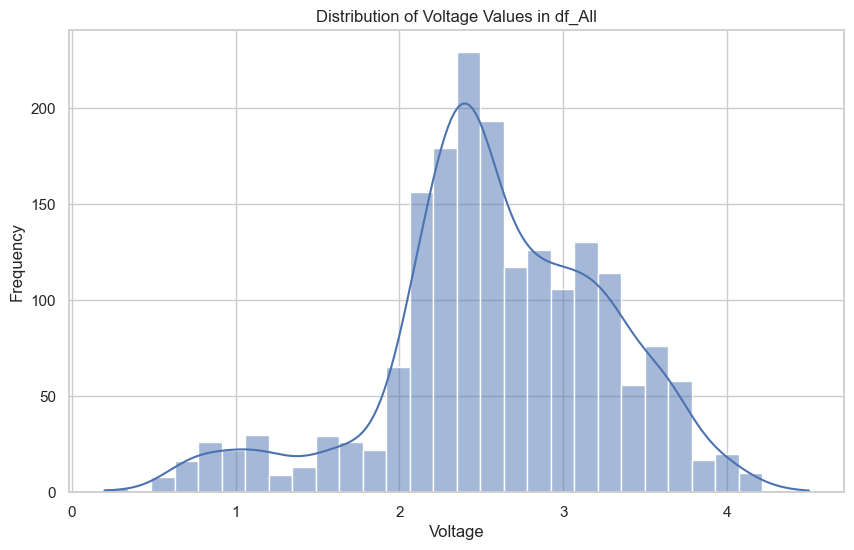

In [7]:
# Create the plot for Voltage distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_All['Voltage'], bins=30, kde=True)
plt.title('Distribution of Voltage Values in df_All')
plt.xlabel('Voltage')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Filter the DataFrame for voltage values greater than 2.5
high_voltage_df_All = df_All[df_All['Voltage'] > 2.5]

# Count the number of rows with voltage values greater than 2.5
num_high_voltage_All = high_voltage_df_All.shape[0]

percent_All = round((num_high_voltage_All/df_All.shape[0]) * 100, 2)

print(f"Number of voltage values in df_All greater than 2.5: {num_high_voltage_All}")
print(f"Percentage: {percent_All}%")

Number of voltage values in df_All greater than 2.5: 963
Percentage: 51.86%


In [9]:
Voltage_threshold = 2.5

df_All['target'] = (df_All['Voltage'] > Voltage_threshold).astype(int)

In [10]:
df_All = df_All[df_All['length'] <= 250]

In [11]:
df_All.shape

(1856, 4)

In [12]:
df_All.head()

,Voltage,SMILES,length,target
0,2.95,O=C1C2=C(O)C=CC(O)=C2C(=O)C2=C1C(=O)C1=C(C2=O)...,87,1
1,2.40,O=C(C1=C(C(S(=O)(O[Na])=O)=CC=C1)C2=O)C3=C2C=C...,64,0
2,2.40,OC(C1=C2C=CC=C1S(=O)(O)=O)=C3C(C(S(=O)(O)=O)=C...,55,0
3,2.25,O=C1C2=C(C=CC=C2)C(=O)C2=C1C=CC=C2S(=O)(=O)O[Na],48,0
4,2.25,OC(C1=C2C=CC=C1S(=O)(O)=O)=C3C(C=CC=C3)=C2O,43,0


In [13]:
# Reset the index of df_All after deleting columns
df_All = df_All.reset_index(drop=True)

# Sanitization - SELFIES - Encoding

In [14]:
import pandas as pd
import selfies as sf
from rdkit import Chem
from rdkit.Chem import MolToSmiles
from rdkit import RDLogger
from sklearn.base import BaseEstimator, TransformerMixin

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.error')

class SMILESToSELFIESTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pad_to_len=None):
        self.pad_to_len = pad_to_len
        self.symbol_to_idx = None
        self.idx_to_symbol = None

    def sanitize_smiles(self, smiles):
        try:
            # Replace '.' with 'X'
            smiles = smiles.replace('.', 'X')
            mol = Chem.MolFromSmiles(smiles, sanitize=True)
            if mol is not None:
                return MolToSmiles(mol, canonical=True)
            else:
                return None
        except:
            return None

    def smiles_to_selfies(self, smiles):
        sanitized_smiles = self.sanitize_smiles(smiles)
        if sanitized_smiles:
            try:
                return sf.encoder(sanitized_smiles)
            except sf.EncoderError:
                return None
        return None

    def build_vocabulary(self, selfies_list):
        alphabet = sf.get_alphabet_from_selfies(selfies_list)
        alphabet.add("[nop]")  # [nop] is a special padding symbol
        self.alphabet = list(sorted(alphabet))
        self.symbol_to_idx = {s: i for i, s in enumerate(self.alphabet)}
        self.idx_to_symbol = {i: s for i, s in enumerate(self.alphabet)}

    def selfies_to_numerical(self, selfies):
        if not self.symbol_to_idx:
            raise ValueError("Vocabulary is not built. Call build_vocabulary first.")
        label, one_hot = sf.selfies_to_encoding(
            selfies=selfies,
            vocab_stoi=self.symbol_to_idx,
            pad_to_len=self.pad_to_len,
            enc_type="both"
        )
        return label

    def print_alphabet_list(self):
        if self.alphabet:
            print("Alphabet list:", self.alphabet)
        else:
            print("Alphabet list has not been built yet.")
    
    def fit(self, X, y=None):
        X = X.copy()
        # Convert SMILES to SELFIES
        X['selfies'] = X['smiles'].apply(self.smiles_to_selfies)
        
        # Filter out rows with invalid SELFIES
        X = X.dropna(subset=['selfies'])

        # Build vocabulary
        selfies_list = X['selfies'].tolist()
        self.build_vocabulary(selfies_list)

        # Determine pad_to_len if not specified
        if self.pad_to_len is None:
            self.pad_to_len = max(sf.len_selfies(s) for s in selfies_list)
        
        return self

    def transform(self, X, y=None):
        X = X.copy()
        # Convert SMILES to SELFIES (if not already done in fit)
        if 'selfies' not in X.columns:
            X['selfies'] = X['smiles'].apply(self.smiles_to_selfies)
        
        # Filter out rows with invalid SELFIES
        X = X.dropna(subset=['selfies'])

        # Convert SELFIES to numerical IDs
        X['numerical_ids'] = X['selfies'].apply(self.selfies_to_numerical)
        
        #return X[['numerical_ids']]

        # Convert the list of numerical IDs into a DataFrame
        numerical_ids_df = pd.DataFrame(X['numerical_ids'].tolist())
        
        return numerical_ids_df

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


In [15]:
# Show full length
pd.set_option('display.max_colwidth', None)

#### IDs for df_All

In [16]:
df_trans_All = pd.DataFrame()
df_trans_All['smiles'] = df_All['SMILES']
trans_All = SMILESToSELFIESTransformer()
IDs_All = trans_All.fit_transform(df_trans_All)

In [17]:
# Retrieve the calculated pad_to_len
print("Computed pad_to_len:", trans_All.pad_to_len)

Computed pad_to_len: 175


In [18]:
IDs_All.head()

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
0,38,12,26,12,22,26,38,26,12,26,...,49,49,49,49,49,49,49,49,49,49
1,38,12,26,12,26,12,26,22,1,43,...,49,49,49,49,49,49,49,49,49,49
2,38,19,10,26,15,22,26,38,26,12,...,49,49,49,49,49,49,49,49,49,49
3,38,12,26,12,26,12,26,12,40,10,...,49,49,49,49,49,49,49,49,49,49
4,38,19,10,26,15,22,26,38,26,12,...,49,49,49,49,49,49,49,49,49,49


In [19]:
# Call print_alphabet_list() to print the alphabet list
trans_All.print_alphabet_list()

Alphabet list: ['[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[-\\Ring1]', '[-\\Ring2]', '[/C]', '[/N]', '[/O]', '[/S]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N+1]', '[=N]', '[=O]', '[=P]', '[=Ring1]', '[=Ring2]', '[=S]', '[B]', '[Br]', '[Branch1]', '[Branch2]', '[C@@H1]', '[C@H1]', '[C]', '[Cl]', '[F]', '[I]', '[Li]', '[N+1]', '[N-1]', '[NH1]', '[N]', '[Na]', '[O-1]', '[OH0]', '[O]', '[P]', '[Ring1]', '[Ring2]', '[S+1]', '[S]', '[\\C]', '[\\F]', '[\\N]', '[\\O]', '[\\S]', '[nop]']


In [20]:
trans_All.fit(df_trans_All)

SMILESToSELFIESTransformer(pad_to_len=175)

In [21]:
# Print the mapping from numerical IDs to SELFIES tokens
print("Numerical ID to Token mapping for df_P:")
for idx, token in trans_All.idx_to_symbol.items():
    print(f"ID {idx}: {token}")

Numerical ID to Token mapping for df_P:
ID 0: [#Branch1]
ID 1: [#Branch2]
ID 2: [#C]
ID 3: [#N]
ID 4: [-\Ring1]
ID 5: [-\Ring2]
ID 6: [/C]
ID 7: [/N]
ID 8: [/O]
ID 9: [/S]
ID 10: [=Branch1]
ID 11: [=Branch2]
ID 12: [=C]
ID 13: [=N+1]
ID 14: [=N]
ID 15: [=O]
ID 16: [=P]
ID 17: [=Ring1]
ID 18: [=Ring2]
ID 19: [=S]
ID 20: [B]
ID 21: [Br]
ID 22: [Branch1]
ID 23: [Branch2]
ID 24: [C@@H1]
ID 25: [C@H1]
ID 26: [C]
ID 27: [Cl]
ID 28: [F]
ID 29: [I]
ID 30: [Li]
ID 31: [N+1]
ID 32: [N-1]
ID 33: [NH1]
ID 34: [N]
ID 35: [Na]
ID 36: [O-1]
ID 37: [OH0]
ID 38: [O]
ID 39: [P]
ID 40: [Ring1]
ID 41: [Ring2]
ID 42: [S+1]
ID 43: [S]
ID 44: [\C]
ID 45: [\F]
ID 46: [\N]
ID 47: [\O]
ID 48: [\S]
ID 49: [nop]


#### Save and reuse embeddings

Using the same embedding, alphabet list, length, and padding from your trained SMILESToSELFIESTransformer class for screening molecules in a database

Save the Fitted Transformer Information: After fitting the transformer on your current dataset, save the vocabulary (symbol_to_idx, idx_to_symbol), alphabet, and pad_to_len. This ensures consistency when transforming the SMILES data from the new database.

In [33]:
import pickle

# After fitting the transformer
transformer = SMILESToSELFIESTransformer(pad_to_len=175)
transformer.fit(df_trans_All)

# Save the transformer state
with open('transformer_state.pkl', 'wb') as f:
    pickle.dump({
        'symbol_to_idx': transformer.symbol_to_idx,
        'idx_to_symbol': transformer.idx_to_symbol,
        'alphabet': transformer.alphabet,
        'pad_to_len': transformer.pad_to_len
    }, f)


Load the Fitted Transformer Information: When applying the transformer to the new dataset (e.g., the database of molecules), load the saved transformer state and use the same settings (vocabulary, padding length, etc.).

In [ ]:
'''
# Load the transformer state
with open('transformer_state.pkl', 'rb') as f:
    state = pickle.load(f)

# Initialize transformer with saved state
transformer = SMILESToSELFIESTransformer(pad_to_len=state['pad_to_len'])
transformer.symbol_to_idx = state['symbol_to_idx']
transformer.idx_to_symbol = state['idx_to_symbol']
transformer.alphabet = state['alphabet']

# Transform the new database (df_new)
df_new_numerical_ids = transformer.transform(df_new)

'''

In [22]:
IDs_All.shape

(1856, 175)

In [23]:
# Assign 'Augmented' and 'target' columns from df_All to IDs_All
IDs_All[['target']] = df_All[['target']]


In [24]:
IDs_All.head()

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,target
0,38,12,26,12,22,26,38,26,12,26,...,49,49,49,49,49,49,49,49,49,1
1,38,12,26,12,26,12,26,22,1,43,...,49,49,49,49,49,49,49,49,49,0
2,38,19,10,26,15,22,26,38,26,12,...,49,49,49,49,49,49,49,49,49,0
3,38,12,26,12,26,12,26,12,40,10,...,49,49,49,49,49,49,49,49,49,0
4,38,19,10,26,15,22,26,38,26,12,...,49,49,49,49,49,49,49,49,49,0


### XGBoost

In [25]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(IDs_All, test_size=0.2, random_state=42)



In [26]:
train_df.shape

(1484, 176)

In [27]:
test_df.shape

(372, 176)

In [28]:
train_df.to_csv('train_df_IDs.csv', index=False)
test_df.to_csv('test_df_IDs.csv', index=False)

In [29]:
# Define X_train as the feature columns (exclude 'target')
X_train_All = train_df.drop(columns=['target'])

# Define y_train as the 'target' column
y_train_All = train_df['target']


In [30]:
# Define X_test as the feature columns (exclude 'target')
X_test_All = test_df.drop(columns=['target'])

# Define y_test as the 'target' column
y_test_All = test_df['target']

In [31]:
X_train_All.head()

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
244,26,26,22,26,26,26,12,26,12,26,...,49,49,49,49,49,49,49,49,49,49
1683,38,12,26,12,26,12,26,12,40,10,...,49,49,49,49,49,49,49,49,49,49
1073,26,43,10,26,15,10,26,15,7,12,...,49,49,49,49,49,49,49,49,49,49
1080,26,43,10,26,15,10,26,15,7,12,...,49,49,49,49,49,49,49,49,49,49
1228,26,43,10,26,15,10,26,15,7,12,...,49,49,49,49,49,49,49,49,49,49


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, precision_score, roc_auc_score, accuracy_score


In [33]:
pipeline_xgb_All = Pipeline([
    ('scaler', StandardScaler()),            # Scale the numerical features
    ('model', XGBClassifier(random_state=42))
])

In [34]:
pipeline_xgb_All.fit(X_train_All, y_train_All)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [35]:
# Predict labels for both the train and test sets
y_train_pred_xgb_All = pipeline_xgb_All.predict(X_train_All)
y_test_pred_xgb_All = pipeline_xgb_All.predict(X_test_All)

# Predict probabilities for both the train and test sets to compute AUC-ROC
y_train_pred_proba_xgb_All = pipeline_xgb_All.predict_proba(X_train_All)[:, 1]  # Probability for class 1
y_test_pred_proba_xgb_All = pipeline_xgb_All.predict_proba(X_test_All)[:, 1]    # Probability for class 1

# Compute precision, AUC-ROC, and accuracy for the train set
train_precision_xgb_All = precision_score(y_train_All, y_train_pred_xgb_All)
train_auc_roc_xgb_All = roc_auc_score(y_train_All, y_train_pred_proba_xgb_All)
train_accuracy_xgb_All = accuracy_score(y_train_All, y_train_pred_xgb_All)

# Compute precision, AUC-ROC, and accuracy for the test set
test_precision_xgb_All = precision_score(y_test_All, y_test_pred_xgb_All)
test_auc_roc_xgb_All = roc_auc_score(y_test_All, y_test_pred_proba_xgb_All)
test_accuracy_xgb_All = accuracy_score(y_test_All, y_test_pred_xgb_All)

# Print the results for the train set
print("Train set scores:")
print(f"Precision: {train_precision_xgb_All:.4f}")
print(f"AUC-ROC: {train_auc_roc_xgb_All:.4f}")
print(f"Accuracy: {train_accuracy_xgb_All:.4f}\n")

# Print the results for the test set
print("Test set scores:")
print(f"Precision: {test_precision_xgb_All:.4f}")
print(f"AUC-ROC: {test_auc_roc_xgb_All:.4f}")
print(f"Accuracy: {test_accuracy_xgb_All:.4f}")

Train set scores:
Precision: 0.9922
AUC-ROC: 0.9995
Accuracy: 0.9885

Test set scores:
Precision: 0.8032
AUC-ROC: 0.8575
Accuracy: 0.8038


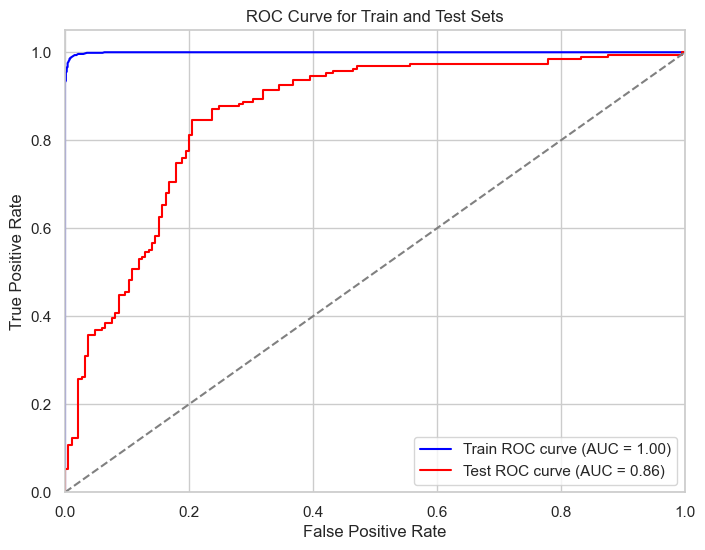

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for the training set
fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train_All, y_train_pred_proba_xgb_All)
roc_auc_train_xgb = auc(fpr_train_xgb, tpr_train_xgb)

# Compute ROC curve and AUC for the test set
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test_All, y_test_pred_proba_xgb_All)
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)

# Plot ROC curves for both training and test sets
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_xgb, tpr_train_xgb, color='blue', label=f'Train ROC curve (AUC = {roc_auc_train_xgb:.2f})')
plt.plot(fpr_test_xgb, tpr_test_xgb, color='red', label=f'Test ROC curve (AUC = {roc_auc_test_xgb:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Train and Test Sets')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


c:\Users\xueli\miniconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\xueli\miniconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


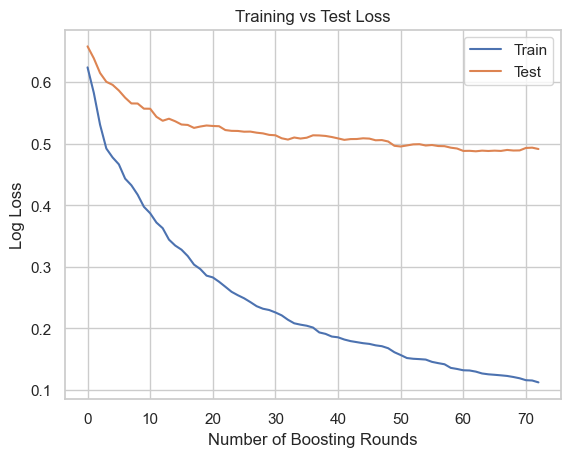

In [37]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_All)
X_test_scaled = scaler.transform(X_test_All)

# Define the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Fit the model with early stopping and validation set
xgb_model.fit(
    X_train_scaled, y_train_All,
    eval_set=[(X_train_scaled, y_train_All), (X_test_scaled, y_test_All)],
    eval_metric='logloss',
    early_stopping_rounds=10,
    verbose=False
)

# Get the evaluation results
results_xgb = xgb_model.evals_result()

# Plot training and validation loss
plt.plot(results_xgb['validation_0']['logloss'], label='Train')
plt.plot(results_xgb['validation_1']['logloss'], label='Test')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.show()


### HyperOpt

##### Exhaustive Tuning with Hyperopt

In [38]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score  

from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], 
                    X_train: pd.DataFrame, y_train: pd.Series, 
                    X_test: pd.DataFrame, y_test: pd.Series, 
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.

    This function takes a dictionary of hyperparameters, training 
    and test data, and an optional value for early stopping rounds, 
    and returns a dictionary with the loss and model resulting from 
    the tuning process. The model is trained using the training 
    data and evaluated on the test data. The loss is computed as 
    the negative of the accuracy score.

    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value 
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy

    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the 
        tuning process. The loss is a float, and the model is an 
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                  (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation, 
              verbose=False)    
         
    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [39]:
import xgboost as xgb

In [40]:
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 1, 10),
    'gamma': hp.loguniform('gamma', -10, 10), # regularization
    'learning_rate': hp.loguniform('learning_rate', -7, 0),  # boosting
    'random_state': 42
}

trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train_scaled, y_train_All, 
                                                   X_test_scaled, y_test_All),            
    space=options,           
    algo=tpe.suggest,            
    max_evals=2_000,            
    trials=trials,
    #timeout=60*5 # 5 minutes
)

100%|██████████| 2000/2000 [09:55<00:00,  3.36trial/s, best loss: -0.8494623655913979]


In [41]:
best_params = best.copy()

# Cast `max_depth` (quniform) to an integer
best_params['max_depth'] = int(best_params['max_depth'])

# Cast `min_child_weight` to a float, if needed
best_params['min_child_weight'] = float(best_params['min_child_weight'])

# The rest of the parameters are ready as they are
print("Processed Best Parameters:", best_params)


Processed Best Parameters: {'colsample_bytree': 0.7587969946598169, 'gamma': 0.02723054976629227, 'learning_rate': 0.17941102558227404, 'max_depth': 8, 'min_child_weight': 0.1778845752916189, 'reg_alpha': 0.1913727343070526, 'reg_lambda': 4.89734985611746, 'subsample': 0.7361833899421435}


In [42]:
xgb_best_model = XGBClassifier(
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    random_state=42,
    n_estimators=500  # Large number of estimators, early stopping will choose the best
)

# Train the best model with early stopping
xgb_best_model.fit(
    X_train_scaled, y_train_All,
    eval_set=[(X_train_scaled, y_train_All), (X_test_scaled, y_test_All)],  # Train and validation sets
    early_stopping_rounds=50,  # Stop if no improvement after 50 rounds
    verbose=True  # To monitor the early stopping process
)

# Best iteration can be accessed as:
print(f"Best iteration (number of trees used): {xgb_best_model.best_iteration + 1}")



[0]	validation_0-logloss:0.66220	validation_1-logloss:0.68195
[1]	validation_0-logloss:0.61539	validation_1-logloss:0.65885


[2]	validation_0-logloss:0.57987	validation_1-logloss:0.63756
[3]	validation_0-logloss:0.55219	validation_1-logloss:0.62506
[4]	validation_0-logloss:0.52807	validation_1-logloss:0.60802
[5]	validation_0-logloss:0.50201	validation_1-logloss:0.59538
[6]	validation_0-logloss:0.47826	validation_1-logloss:0.58148
[7]	validation_0-logloss:0.45929	validation_1-logloss:0.57119
[8]	validation_0-logloss:0.44097	validation_1-logloss:0.56239
[9]	validation_0-logloss:0.43032	validation_1-logloss:0.55776
[10]	validation_0-logloss:0.41773	validation_1-logloss:0.55280
[11]	validation_0-logloss:0.40106	validation_1-logloss:0.54655
[12]	validation_0-logloss:0.38591	validation_1-logloss:0.54124
[13]	validation_0-logloss:0.37181	validation_1-logloss:0.53389
[14]	validation_0-logloss:0.35991	validation_1-logloss:0.52673
[15]	validation_0-logloss:0.35289	validation_1-logloss:0.52305
[16]	validation_0-logloss:0.34159	validation_1-logloss:0.52177
[17]	validation_0-logloss:0.33557	validation_1-logloss:0.51877


c:\Users\xueli\miniconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-logloss:0.28435	validation_1-logloss:0.49093
[24]	validation_0-logloss:0.27539	validation_1-logloss:0.48675
[25]	validation_0-logloss:0.26981	validation_1-logloss:0.48524
[26]	validation_0-logloss:0.26414	validation_1-logloss:0.48127
[27]	validation_0-logloss:0.25767	validation_1-logloss:0.47759
[28]	validation_0-logloss:0.25010	validation_1-logloss:0.47378
[29]	validation_0-logloss:0.24372	validation_1-logloss:0.47498
[30]	validation_0-logloss:0.23980	validation_1-logloss:0.47151
[31]	validation_0-logloss:0.23457	validation_1-logloss:0.47060
[32]	validation_0-logloss:0.22944	validation_1-logloss:0.46893
[33]	validation_0-logloss:0.22518	validation_1-logloss:0.46694
[34]	validation_0-logloss:0.22074	validation_1-logloss:0.46534
[35]	validation_0-logloss:0.21674	validation_1-logloss:0.46279
[36]	validation_0-logloss:0.21222	validation_1-logloss:0.46241
[37]	validation_0-logloss:0.20808	validation_1-logloss:0.46099
[38]	validation_0-logloss:0.20433	validation_1-logloss:

In [43]:
# Retrieve the best number of estimators based on early stopping
best_n_estimators = xgb_best_model.best_iteration + 1  # Add 1 as it is 0-indexed

# Use the best n_estimators for final model training
final_model = XGBClassifier(
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    random_state=42,
    n_estimators=best_n_estimators  # Set to best iteration value
)

# Train the final model on the full dataset
final_model.fit(X_train_scaled, y_train_All)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7587969946598169, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.02723054976629227,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17941102558227404,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=0.1778845752916189, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=121,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [44]:
from sklearn.metrics import precision_score, roc_auc_score, f1_score, accuracy_score

# Predict probabilities for AUC-ROC calculation
y_train_pred_prob = final_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_prob = final_model.predict_proba(X_test_scaled)[:, 1]

# Predict class labels
y_train_pred = final_model.predict(X_train_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# Calculate metrics for the training set
train_precision = precision_score(y_train_All, y_train_pred)
train_auc_roc = roc_auc_score(y_train_All, y_train_pred_prob)
train_f1 = f1_score(y_train_All, y_train_pred)
train_accuracy = accuracy_score(y_train_All, y_train_pred)

# Calculate metrics for the test set
test_precision = precision_score(y_test_All, y_test_pred)
test_auc_roc = roc_auc_score(y_test_All, y_test_pred_prob)
test_f1 = f1_score(y_test_All, y_test_pred)
test_accuracy = accuracy_score(y_test_All, y_test_pred)

# Print metrics for both sets
print(f"Train Set Metrics:\nPrecision: {train_precision:.4f}\nAUC-ROC: {train_auc_roc:.4f}\nAccuracy: {train_accuracy:.4f}\nF1-Score: {train_f1:.4f}")
print("\n")
print(f"Test Set Metrics:\nPrecision: {test_precision:.4f}\nAUC-ROC: {test_auc_roc:.4f}\nAccuracy: {test_accuracy:.4f}\nF1-Score: {test_f1:.4f}")


Train Set Metrics:
Precision: 0.9897
AUC-ROC: 0.9996
Accuracy: 0.9892
F1-Score: 0.9897


Test Set Metrics:
Precision: 0.8238
AUC-ROC: 0.8887
Accuracy: 0.8333
F1-Score: 0.8368


In [45]:
# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print all hyperparameters
for param, value in params.items():
    print(f"{param}: {value}")

objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: 0.7587969946598169
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: 0.02723054976629227
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.17941102558227404
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 8
max_leaves: None
min_child_weight: 0.1778845752916189
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 121
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: 0.1913727343070526
reg_lambda: 4.89734985611746
sampling_method: None
scale_pos_weight: None
subsample: 0.7361833899421435
tree_method: None
validate_parameters: None
verbosity: None


#### Further hyperparameter tuning manually

##### Regularization

In [66]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for reg_lambda and reg_alpha
print(f"Current reg_alpha: {params['reg_alpha']}")
print(f"Current reg_lambda: {params['reg_lambda']}")

# Increase the values of reg_alpha and reg_lambda
params['reg_alpha'] = params['reg_alpha'] * 123  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 21  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Current reg_alpha: 0.1913727343070526
Current reg_lambda: 4.89734985611746
Train Set Metrics:
Train Accuracy: 0.7500
Train Precision: 0.7317
Train AUC-ROC: 0.8291
Train F1-Score: 0.7747

Test Set Metrics:
Test Accuracy: 0.6613
Test Precision: 0.6432
Test AUC-ROC: 0.7263
Test F1-Score: 0.6850


In [58]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for reg_lambda and reg_alpha
print(f"Current reg_alpha: {params['reg_alpha']}")
print(f"Current reg_lambda: {params['reg_lambda']}")

# Increase the values of reg_alpha and reg_lambda
params['reg_alpha'] = params['reg_alpha'] * 130  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 20  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Current reg_alpha: 0.1913727343070526
Current reg_lambda: 4.89734985611746
Train Set Metrics:
Train Accuracy: 0.7318
Train Precision: 0.7060
Train AUC-ROC: 0.8203
Train F1-Score: 0.7645

Test Set Metrics:
Test Accuracy: 0.6613
Test Precision: 0.6406
Test AUC-ROC: 0.7227
Test F1-Score: 0.6881


##### Regularization and max_depth

In [63]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for max_depth
print(f"Current max_depth: {params['max_depth']}")

# Increase the values of reg_alpha and reg_lambda
params['max_depth'] = 7  # Decrease max_depth
params['reg_alpha'] = params['reg_alpha'] * 130  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 20  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Current max_depth: 8
Train Set Metrics:
Train Accuracy: 0.7224
Train Precision: 0.6997
Train AUC-ROC: 0.8087
Train F1-Score: 0.7553

Test Set Metrics:
Test Accuracy: 0.6532
Test Precision: 0.6330
Test AUC-ROC: 0.7199
Test F1-Score: 0.6815


In [67]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for max_depth
print(f"Current max_depth: {params['max_depth']}")

# Increase the values of reg_alpha and reg_lambda
params['max_depth'] = 5  # Decrease max_depth
params['reg_alpha'] = params['reg_alpha'] * 130  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 20  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Current max_depth: 8
Train Set Metrics:
Train Accuracy: 0.7008
Train Precision: 0.6817
Train AUC-ROC: 0.7852
Train F1-Score: 0.7367

Test Set Metrics:
Test Accuracy: 0.6425
Test Precision: 0.6239
Test AUC-ROC: 0.7033
Test F1-Score: 0.6716


##### Regularization, max_depth and min_child_weight

In [69]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for max_depth
print(f"min_child_weight: {params['min_child_weight']}")

# Increase the values of reg_alpha and reg_lambda
params['max_depth'] = 7  # Decrease max_depth
params['min_child_weight'] = 1.5  # Increase min_child_weight
params['reg_alpha'] = params['reg_alpha'] * 130  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 20  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


min_child_weight: 0.1778845752916189
Train Set Metrics:
Train Accuracy: 0.7325
Train Precision: 0.7081
Train AUC-ROC: 0.8119
Train F1-Score: 0.7641

Test Set Metrics:
Test Accuracy: 0.6720
Test Precision: 0.6512
Test AUC-ROC: 0.7212
Test F1-Score: 0.6965


##### Regularization, max_depth, min_child_weight, learning rate and n_estimators

In [104]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for max_depth
print(f"learning_rate: {params['learning_rate']}")
print(f"n_estimators: {params['n_estimators']}")

# Increase the values of reg_alpha and reg_lambda
params['learning_rate'] = 0.1245  # Try smaller values (e.g., 0.05 or 0.01)
params['n_estimators'] = 112  # Increase n_estimators when reducing learning_rate
params['max_depth'] = 5  # Decrease max_depth
params['min_child_weight'] = 2.3519  # Increase min_child_weight
params['reg_alpha'] = params['reg_alpha'] * 150  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 80  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


learning_rate: 0.12453337564418783
n_estimators: 112
Train Set Metrics:
Train Accuracy: 0.8188
Train Precision: 0.8080
Train AUC-ROC: 0.8994
Train F1-Score: 0.8433

Test Set Metrics:
Test Accuracy: 0.7417
Test Precision: 0.7607
Test AUC-ROC: 0.7973
Test F1-Score: 0.7744


##### Add early stopping on the selected parameters based on the results above

In [105]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, f1_score

# Get all hyperparameters of the final_model
params = final_model.get_params()

# Print current values for max_depth
print(f"Current reg_alpha: {params['reg_alpha']}")
print(f"Current reg_lambda: {params['reg_lambda']}")
print(f"Current max_depth: {params['max_depth']}")

# Increase the values of reg_alpha and reg_lambda
params['max_depth'] = 5  # Decrease max_depth
params['reg_alpha'] = params['reg_alpha'] * 150  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 80  # Increase reg_lambda
params['early_stopping_rounds'] = 15  # Add early stopping
params['eval_metric'] = 'auc'

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Fit the model on your training data
updated_model.fit(X_train_scaled, y_train_All, 
                  eval_set=[(X_test_scaled, y_test_All)],
                  verbose=False)

# Predictions on Train Set
y_train_pred = updated_model.predict(X_train_scaled)
y_train_pred_proba = updated_model.predict_proba(X_train_scaled)[:, 1]

# Predictions on Test Set
y_test_pred = updated_model.predict(X_test_scaled)
y_test_pred_proba = updated_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics for Train Set
train_accuracy = accuracy_score(y_train_All, y_train_pred)
train_precision = precision_score(y_train_All, y_train_pred)
train_roc_auc = roc_auc_score(y_train_All, y_train_pred_proba)
train_f1 = f1_score(y_train_All, y_train_pred)

# Calculate metrics for Test Set
test_accuracy = accuracy_score(y_test_All, y_test_pred)
test_precision = precision_score(y_test_All, y_test_pred)
test_roc_auc = roc_auc_score(y_test_All, y_test_pred_proba)
test_f1 = f1_score(y_test_All, y_test_pred)

# Print all the required scores for Train Set
print("Train Set Metrics:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train AUC-ROC: {train_roc_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")

# Print all the required scores for Test Set
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test AUC-ROC: {test_roc_auc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Current reg_alpha: 0.17645719033489465
Current reg_lambda: 2.4020812894310786
Current max_depth: 8
Train Set Metrics:
Train Accuracy: 0.8161
Train Precision: 0.8047
Train AUC-ROC: 0.8990
Train F1-Score: 0.8412

Test Set Metrics:
Test Accuracy: 0.7362
Test Precision: 0.7547
Test AUC-ROC: 0.7974
Test F1-Score: 0.7702


In [151]:
# Get all hyperparameters of the final_model
params = final_model.get_params()

# Update parameters
params['max_depth'] = 4  # Decrease max_depth
params['reg_alpha'] = params['reg_alpha'] * 48  # Increase reg_alpha
params['reg_lambda'] = params['reg_lambda'] * 48  # Increase reg_lambda

# Initialize a new model with updated parameters
updated_model = XGBClassifier(**params)

# Train the model with early stopping, using the test set as validation
updated_model.fit(
    X_train_scaled, y_train_All, 
    eval_set=[(X_test_scaled, y_test_All)],  # Validation dataset is required for early stopping
    verbose=False
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8676236024493804, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None,
              gamma=0.00016947681411963564, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.22958011378015764, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1.3638343304356748, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=63,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

##### 5-Fold cross-validation

In [152]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(updated_model, X_train_scaled, y_train_All, cv=5, scoring='precision')
print(f"Cross-validated precision: {cv_scores.mean():.4f}")


Cross-validated precision: 0.7970


In [153]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score, f1_score

# Cross-validation on the training data
scoring = ['precision', 'roc_auc', 'accuracy', 'f1']

cv_results = cross_validate(updated_model, X_train_scaled, y_train_All, cv=5, scoring=scoring, return_train_score=True)

# Display mean results for each metric on the training data
print(f"5-fold CV Mean Train Precision: {cv_results['train_precision'].mean():.4f}")
print(f"5-fold CV Mean Train AUC-ROC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"5-fold CV Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"5-fold CV Mean Train F1: {cv_results['train_f1'].mean():.4f}")

print(f"5-fold CV Mean Test Precision: {cv_results['test_precision'].mean():.4f}")
print(f"5-fold CV Mean Test AUC-ROC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"5-fold CV Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"5-fold CV Mean Test F1: {cv_results['test_f1'].mean():.4f}")

# Train the model on the full training set and evaluate on the test set
updated_model.fit(X_train_scaled, y_train_All)

# Test set performance
y_test_pred = updated_model.predict(X_test_scaled)
y_test_proba = updated_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for AUC-ROC

print(f"Test Precision: {precision_score(y_test_All, y_test_pred):.4f}")
print(f"Test AUC-ROC: {roc_auc_score(y_test_All, y_test_proba):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test_All, y_test_pred):.4f}")
print(f"Test F1: {f1_score(y_test_All, y_test_pred):.4f}")


5-fold CV Mean Train Precision: 0.8173
5-fold CV Mean Train AUC-ROC: 0.8892
5-fold CV Mean Train Accuracy: 0.7973
5-fold CV Mean Train F1: 0.8165
5-fold CV Mean Test Precision: 0.7970
5-fold CV Mean Test AUC-ROC: 0.8658
5-fold CV Mean Test Accuracy: 0.7713
5-fold CV Mean Test F1: 0.7919
Test Precision: 0.8078
Test AUC-ROC: 0.8417
Test Accuracy: 0.7652
Test F1: 0.7854


#### Save and load the model

Using pickle

In [154]:
import pickle

# Assume updated_model is your fitted model or transformer
with open('updated_model_XGBoost_sep19.pkl', 'wb') as f:
    pickle.dump(updated_model, f)


In [ ]:
# Load the saved model
with open('updated_model_XGBoost_sep19.pkl', 'rb') as f:
    updated_model = pickle.load(f)


Using joblib (often faster for larger models)

In [ ]:
'''
from joblib import dump

# Save the updated_model
dump(updated_model, 'updated_model.joblib')
'''


In [ ]:
''' 
from joblib import load

# Load the saved model
updated_model = load('updated_model.joblib')

'''